In [1]:
## Poisson Equation in 1D with Dirichlet BC's ##
# Equation: -(Laplacian)u = pi^2 * sin(pi*x)
# X between -1,1
#BC's: u(-1) = 0, u(1) = 0
#Note: The exact solution is u = sin(pi*x)

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf



Using backend: tensorflow.compat.v1

2022-08-23 18:59:20.832272: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-23 18:59:20.835106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-23 18:59:20.835116: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2022-08-23 18:59:21.801744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-23 18:59:21.801764: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-23 18:59:21.801777: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tony-ThinkBook-15-G4-IAP): /proc/driver/nvidia/version does not exist


In [2]:
geom = dde.geometry.Interval(-1,1)

def pde(x,y): #y is what we're calling u(x)
    dy_xx = dde.grad.hessian(y,x)
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x) #Why use tf sin an not np sin here?
    #Return the residual of the PDE

def boundary(x, on_boundary): #X is a d-dimensional vector, 1 in this case.
    return on_boundary #on_boundary is built in to deepXDE?

def func(x): #Func returns the value for a Dirichlet BC on our domain
    return np.sin(np.pi * x) 

bc = dde.DirichletBC(geom, func, boundary) #Note that in this case, func is the exact solution too

data = dde.data.PDE(geom, pde, bc, 16, 2, solution = func, num_test = 100)

/home/tony/.local/lib/python3.10/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+18=18. 
  warnings.warn("The balance properties of Sobol' points require "


Compiling model...
Building feed-forward neural network...
'build' took 0.028398 s

'compile' took 0.181434 s



/home/tony/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-08-23 18:59:22.740966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 18:59:22.897593: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [4.63e+01, 3.14e-03]    [4.89e+01, 3.14e-03]    [9.61e-01]    
1000      [2.82e-04, 8.95e-08]    [5.40e-04, 8.95e-08]    [2.56e-03]    
2000      [7.09e-05, 5.21e-09]    [2.05e-04, 5.21e-09]    [1.71e-03]    
3000      [4.42e-05, 6.16e-07]    [1.49e-04, 6.16e-07]    [1.28e-03]    
4000      [2.16e-04, 5.14e-06]    [2.29e-04, 5.14e-06]    [1.76e-03]    
5000      [1.67e-05, 9.59e-10]    [8.13e-05, 9.59e-10]    [4.34e-04]    
6000      [1.32e-05, 4.51e-08]    [8.07e-05, 4.51e-08]    [4.26e-04]    
7000      [5.52e-04, 2.27e-05]    [6.46e-04, 2.27e-05]    [6.90e-03]    
8000      [3.42e-04, 4.28e-06]    [3.85e-04, 4.28e-06]    [3.86e-03]    
9000      [1.18e-05, 4.86e-07]    [7.17e-05, 4.86e-07]    [6.27e-04]    
10000     [6.74e-06, 4.14e-08]    [8.99e-05, 4.14e-08]    [2.56e-04]    

Best model at step 10000:
  train loss: 6.79e-06
  test loss: 8.99e-05
  test 

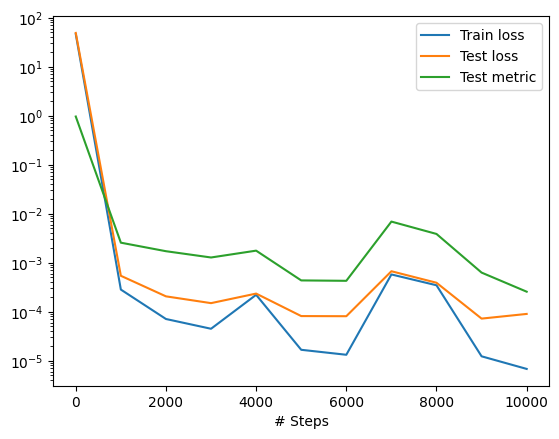

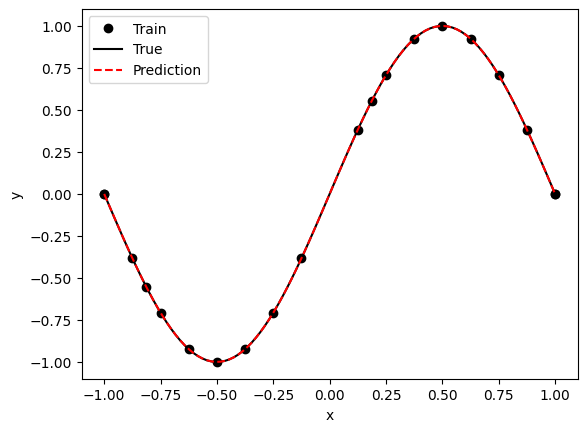

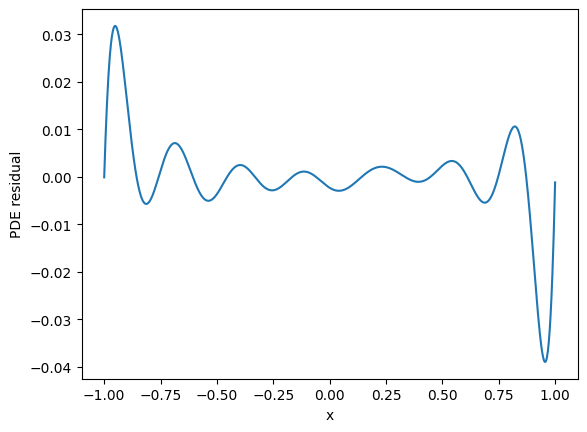

In [3]:
## Choose the network ##
layer_size = [1] + [50]*3 + [1] #3 hidden layers
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

## Build the Model ##
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

## Train the model ##
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Plot PDE residual
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()